# Ensemble NMS - Detectron2 [Inference]

## Install and import libraries

In [1]:
!pip install ../input/ensemble-boxes-104/ensemble_boxes-1.0.4/ -f ./ --no-index

!pip install ../input/detectron-05/whls/pycocotools-2.0.2/dist/pycocotools-2.0.2.tar --no-index --find-links ../input/detectron-05/whls 
!pip install ../input/detectron-05/whls/fvcore-0.1.5.post20211019/fvcore-0.1.5.post20211019 --no-index --find-links ../input/detectron-05/whls 
!pip install ../input/detectron-05/whls/antlr4-python3-runtime-4.8/antlr4-python3-runtime-4.8 --no-index --find-links ../input/detectron-05/whls 
!pip install ../input/detectron-05/whls/detectron2-0.5/detectron2 --no-index --find-links ../input/detectron-05/whls 

Looking in links: ./
Processing /kaggle/input/ensemble-boxes-104/ensemble_boxes-1.0.4
  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
   pip 21.3 will remove support for this functionality. You can find discussion regarding this at https://github.com/pypa/pip/issues/7555.
  Created wheel for ensemble-boxes: filename=ensemble_boxes-1.0.4-py3-none-any.whl size=14070 sha256=299cfcf92459b5970304c8171b1c0cae984ee0bc2291da4954f72800dd6fd43a
  Stored in directory: /root/.cache/pip/wheels/66/11/27/bd684df8a75ad0e720fdc77d199e5876063925350905a64205
Successfully built ensemble-boxes
Looking in links: ../input/detectron-05/whls
Processing /kaggle/input/detectron-05/whls/pycocotools-2.0.2/dist/pycocotools-2.0.2.tar
  Created wheel for pycocotools: filename=pycocotools-2.0.2-cp37-cp37m-linux_x

In [2]:
import detectron2
import torch
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.modeling import GeneralizedRCNNWithTTA
from detectron2.config import get_cfg
from PIL import Image
import cv2
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from fastcore.all import *
detectron2.__version__

import os
import cv2
import json
import time
import numpy as np
import pandas as pd
import torch
import detectron2
from tqdm.auto import tqdm
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.data.datasets import register_coco_instances
from detectron2.evaluation import inference_on_dataset
from detectron2.evaluation.evaluator import DatasetEvaluator
from detectron2.data import DatasetCatalog, build_detection_test_loader
import pycocotools.mask as mask_util
from PIL import Image
import matplotlib.pyplot as plt
from fastcore.all import *
from ensemble_boxes import *


import albumentations as A

os.environ['CUDA_VISIBLE_DEVICES'] = '0' 
if torch.cuda.is_available():
    DEVICE = torch.device('cuda')
    print('GPU is available')
else:
    DEVICE = torch.device('cpu')
    print('CPU is used')
print('detectron ver:', detectron2.__version__)

GPU is available
detectron ver: 0.5


## My Models

[Mask Correction](https://www.kaggle.com/slavkoprytula/mask-correction-mask-filtering-updated?kernelSessionId=80632722)


In [3]:
# best_model=( {'file': 'model_0001999--2.77inference_loss.pth','config_name':'COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml', 'LB score': 0.299,'ths':[.18, .38, .58]},
#              {'file': 'model_0005249-x101-0.265iou.pth','config_name':'COCO-InstanceSegmentation/mask_rcnn_X_101_32x8d_FPN_3x.yaml', 'LB score': 0.301,'ths':[.18, .38, .58]})
#             # {'file': 'model_best_mask_rcnn_R_101_C4_3x.pth','config_name':'COCO-InstanceSegmentation/mask_rcnn_R_101_C4_3x.yaml', 'LB score': 0.268,'ths':[.18, .38, .58]})
#              #{'file': 'model_best_mask_rcnn_R_101_FPN_3x.pth','config_name':'COCO-InstanceSegmentation/mask_rcnn_R_101_FPN_3x.yaml', 'LB score': 0.287,'ths':[.17, .34, .56]})

best_model=( 
#     {'file': '../input/sartoriousresnet50/fold1-cv0277.pth', 'config_name': 'COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml', 'LB score': 0.308, 'ths': [.19, .39, .59]},
#     {'file': '../input/d/slavkoprytula/detectron2cellinstancesegmentation/model_0004799-0.281.pth', 'config_name': 'COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml', 'LB score': 0.306, 'ths': [.15, .35, .58]},
#     {'file': '../input/sartoriousresnet50/model_final_12-0.306LB.pth', 'config_name': 'COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml', 'LB score': 0.306, 'ths': [.15, .35, .55]},
    {'file': '../input/sartoriousresnet50/Z_model_273.pth', 'config_name': 'COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml', 'LB score': 0.308, 'ths': [.15, .35, .55]},
    {'file': '../input/sartoriousresnet50/model_0011999-aug-0.290.pth', 'config_name': "COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml", 'LB score': 0.307, 'ths': [.15, .35, .55]},
           )
# version 03 | NMS of TTA | (HFlip)

In [4]:
mdl_paths = ["../input/sartoriousresnet50/"]
DATA_PATH = "../input/sartorius-cell-instance-segmentation"
MODELS = []
BEST_MODELS =[]
THSS = []
ID_TEST = 0
SUBM_PATH = f'{DATA_PATH}/test'
SINGLE_MODE = False
NMS = True
MIN_PIXELS = [80, 160, 80]
IOU_TH = .30

for b_m in best_model:
    model_name=b_m["file"]
    model_ths=b_m["ths"]
    config_name=b_m["config_name"]
    BEST_MODELS.append(model_name)
    THSS = model_ths
    cfg = get_cfg()
    cfg.merge_from_file(model_zoo.get_config_file(config_name))
    cfg.INPUT.MASK_FORMAT = 'bitmask'
    cfg.MODEL.ROI_HEADS.NUM_CLASSES = 3 
    cfg.MODEL.WEIGHTS = model_name
#     cfg.MODEL.DEVICE = 'cpu'
    cfg.TEST.DETECTIONS_PER_IMAGE = 1000
    MODELS.append(DefaultPredictor(cfg))
print(f'all loaded:\nthresholds: {THSS}\nmodels: {BEST_MODELS}')

all loaded:
thresholds: [0.15, 0.35, 0.55]
models: ['../input/sartoriousresnet50/Z_model_273.pth', '../input/sartoriousresnet50/model_0011999-aug-0.290.pth']


In [5]:
MODELS

## Utils

In [6]:
def TTA(im, predictor, augs, scores, classes, bboxes, masks):

    # perform augmentations
    for aug in augs:
        ima = aug(image=im)['image']
        
        
    # make prediction
    output = predictor(ima)
    
    pred_classes = output['instances'].pred_classes.cpu().numpy().tolist()
    pred_class = max(set(pred_classes), key=pred_classes.count)
    
    take = output['instances'].scores >= THSS[pred_class]
    
    classes.extend(output['instances'].pred_classes[take].cpu().numpy().tolist())
    scores.extend(output['instances'].scores[take].cpu().numpy().tolist())
    
    pred_masks = output['instances'].pred_masks[take].cpu().numpy().astype(np.uint8)
    pred_boxes = output['instances'].pred_boxes[take].tensor.cpu().numpy().tolist()

    for aug in augs:
        data = aug(image=ima, masks=pred_masks, boxes=pred_boxes)
        bboxes.extend(data['boxes'])    
        masks.extend(data['masks'])     
        
    return scores, classes, bboxes, masks

In [7]:
# -- ENCODING / DECODING

def rle_decode(mask_rle, shape=(520, 704)):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height,width) of array to return 
    Returns numpy array, 1 - mask, 0 - background

    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) 
                       for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0] * shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo : hi] = 1
    return img.reshape(shape)  # Needed to align to RLE direction

def rle_encode(img):
    '''
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    
    '''
    pixels = img.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

################################################################################
# -- PREDICTING MASKS

def pred_masks(file_name, path, model, ths, min_pixels):
    img = cv2.imread(f'{path}/{file_name}')
    output = model(img)
    pred_classes = output['instances'].pred_classes.cpu().numpy().tolist()
    pred_class = max(set(pred_classes), key=pred_classes.count)
    take = output['instances'].scores >= ths[pred_class]
    pred_masks = output['instances'].pred_masks[take]
    pred_masks = pred_masks.cpu().numpy()
    result = []
    used = np.zeros(img.shape[:2], dtype=int) 
    for i, mask in enumerate(pred_masks):
        mask = mask * (1 - used)
        if mask.sum() >= min_pixels[pred_class]:
            used += mask
            result.append(rle_encode(mask))
    return result

################################################################################
# -- ENSAMBLING (aka predicting and sampling the data)


def ensemble_preds(file_name, path, models, augmentations, ths):
    img = cv2.imread(f'{path}/{file_name}')
    
    classes = []
    scores = []
    bboxes = []
    masks = []
    
    for model in models:
        for i, aug in enumerate(augmentations):
            scores, classes, bboxes, masks = TTA(img, model, [aug], scores, classes, bboxes, masks)

    assert len(classes) == len(masks) , 'ensemble lenght mismatch'
    scores, classes, bboxes, masks = zip(*sorted(zip(scores, classes, bboxes, masks),reverse=True))
    
    return classes, scores, bboxes, masks



def get_masks_tta(fn, pred, augs_forward, augs_backward, thres=.5):
    im = cv2.imread(str(fn))
    
    # do TTA
    pred_masks, pred_class = TTA(str(fn), pred, augs_forward, augs_backward)
    
    res = []
    used = np.zeros(im.shape[:2], dtype=int) 
    for mask in pred_masks:
        mask = mask * (1 - used)
        if mask.sum() >= MIN_PIXELS[pred_class]: 
            used += mask
            res.append(rle_encode(mask))
          
    return res



################################################################################

def nms_predictions(classes, scores, bboxes, masks, 
                    iou_th=.5, shape=(520, 704)):
    he, wd = shape[0], shape[1]
    boxes_list = [[x[0] / wd, x[1] / he, x[2] / wd, x[3] / he]
                  for x in bboxes]
    scores_list = [x for x in scores]
    labels_list = [x for x in classes]
    nms_bboxes, nms_scores, nms_classes = nms(
        boxes=[boxes_list], 
        scores=[scores_list], 
        labels=[labels_list], 
        weights=None,
        iou_thr=iou_th
    )
    nms_masks = []
    for s in nms_scores:
        nms_masks.append(masks[scores.index(s)])
    nms_scores, nms_classes, nms_masks = zip(*sorted(zip(nms_scores, nms_classes, nms_masks), reverse=True))
    
    return nms_classes, nms_scores, nms_masks

def ensemble_pred_masks(masks, classes, min_pixels, shape=(520, 704)):
    result = []
    pred_class = max(set(classes), key=classes.count)
    used = np.zeros(shape, dtype=int) 
    for i, mask in enumerate(masks):
        mask = mask * (1 - used)
        if mask.sum() >= min_pixels[pred_class]:
            used += mask
            result.append(rle_encode(mask))
    return result

## Demo inference

In [8]:
test_names = os.listdir(SUBM_PATH)
print('test images:', len(test_names))
print('test images:', test_names)

test images: 3
test images: ['7ae19de7bc2a.png', 'd8bfd1dafdc4.png', 'd48ec7815252.png']


In [9]:
encoded_masks_single = pred_masks(
    test_names[ID_TEST], 
    path=SUBM_PATH, 
    model=MODELS[0],
    ths=THSS,
    min_pixels=MIN_PIXELS
)

/opt/conda/lib/python3.7/site-packages/torch/_tensor.py:575: UserWarning: floor_divide is deprecated, and will be removed in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values.
To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor'). (Triggered internally at  /usr/local/src/pytorch/aten/src/ATen/native/BinaryOps.cpp:467.)
  return torch.floor_divide(self, other)


In [10]:
augmentations = [
#     A.HorizontalFlip(p=1.0)
    A.VerticalFlip(p=1.0), 
]

classes, scores, bboxes, masks = ensemble_preds(
    file_name=test_names[ID_TEST] , 
    path=SUBM_PATH, 
    models=MODELS, 
    augmentations=augmentations,
    ths=THSS
)

if NMS:
    classes, scores, masks = nms_predictions(
        classes, 
        scores, 
        bboxes,
        masks, iou_th=IOU_TH
    )
encoded_masks_aug_01 = ensemble_pred_masks(masks, classes, min_pixels=MIN_PIXELS)

In [11]:
augmentations = [
    A.HorizontalFlip(p=1.0), 
#     A.VerticalFlip(p=1.0), 
#     A.Rotate(limit=(180, 180), p=1.0)
]

classes, scores, bboxes, masks = ensemble_preds(
    file_name=test_names[ID_TEST] , 
    path=SUBM_PATH, 
    models=MODELS, 
    augmentations=augmentations,
    ths=THSS
)

if NMS:
    classes, scores, masks = nms_predictions(
        classes, 
        scores, 
        bboxes,
        masks, iou_th=IOU_TH
    )
encoded_masks_aug_02 = ensemble_pred_masks(masks, classes, min_pixels=MIN_PIXELS)

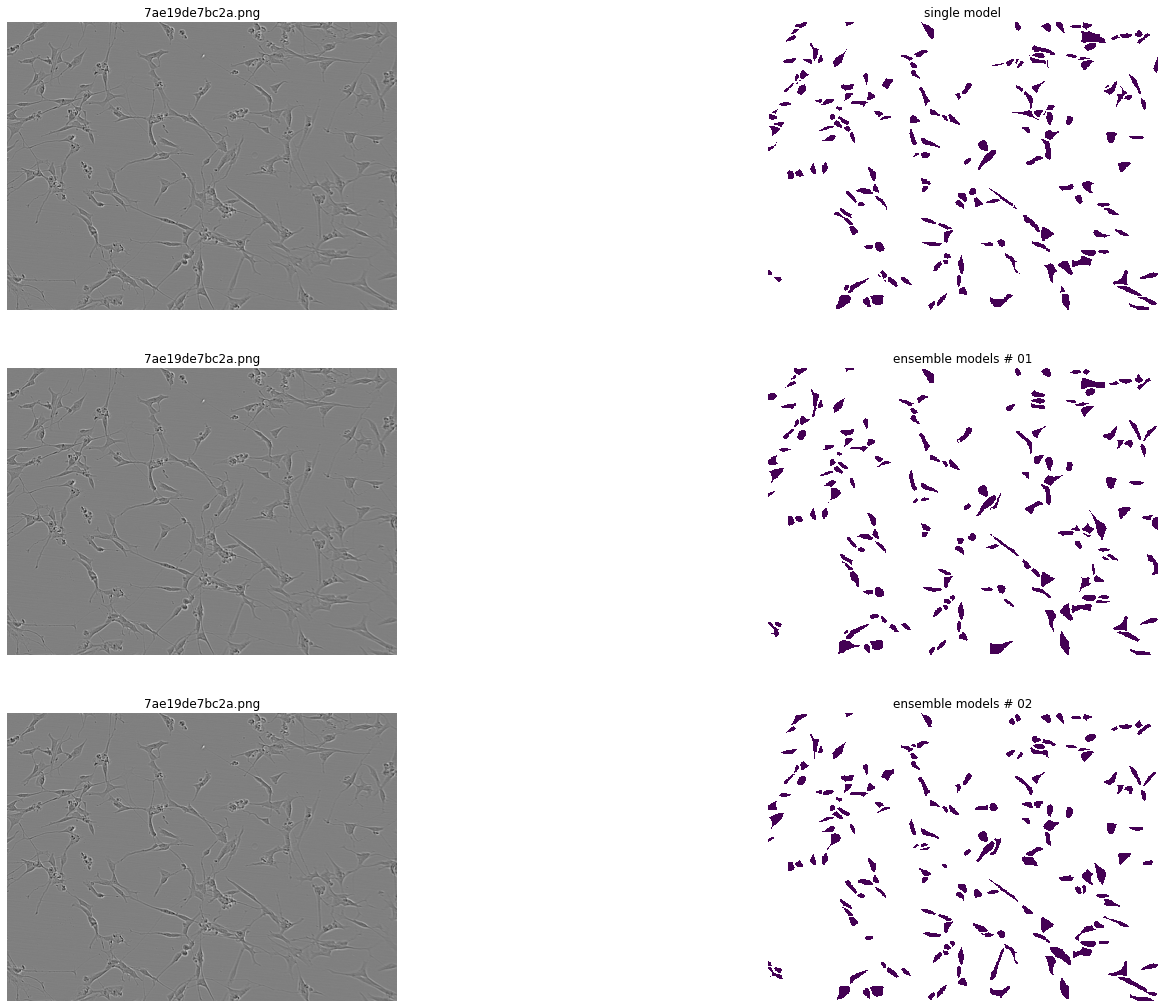

In [12]:
_, axs = plt.subplots(3, 2, figsize=(25, 18))

axs[0][0].imshow(cv2.imread(f'{SUBM_PATH}/{test_names[ID_TEST]}'))
axs[0][0].axis('off')
axs[0][0].set_title(test_names[ID_TEST])
for en_mask in encoded_masks_single:
    dec_mask = rle_decode(en_mask)
    axs[0][1].imshow(np.ma.masked_where(dec_mask == 0, dec_mask))
    axs[0][1].axis('off')
    axs[0][1].set_title('single model')
    
    
# 01 ensamble
axs[1][0].imshow(cv2.imread(f'{SUBM_PATH}/{test_names[ID_TEST]}'))
axs[1][0].axis('off')
axs[1][0].set_title(test_names[ID_TEST])
for en_mask in encoded_masks_aug_01:
    dec_mask = rle_decode(en_mask)
    axs[1][1].imshow(np.ma.masked_where(dec_mask == 0, dec_mask))
    axs[1][1].axis('off')
    axs[1][1].set_title('ensemble models # 01')

    
# 02 ensamble
axs[2][0].imshow(cv2.imread(f'{SUBM_PATH}/{test_names[ID_TEST]}'))
axs[2][0].axis('off')
axs[2][0].set_title(test_names[ID_TEST])
for en_mask in encoded_masks_aug_02:
    dec_mask = rle_decode(en_mask)
    axs[2][1].imshow(np.ma.masked_where(dec_mask == 0, dec_mask))
    axs[2][1].axis('off')
    axs[2][1].set_title('ensemble models # 02')
plt.show()

# TEST

In [13]:
# ID_TEST = 0
# SUBM_PATH = f'{DATA_PATH}/train'
# SINGLE_MODE = False
# NMS = True
# MIN_PIXELS = [75, 150, 75]
# IOU_TH = .2

In [14]:
# test_names = os.listdir(SUBM_PATH)
# print('test images:', len(test_names))
# print('test images:', test_names[:5])

In [15]:
# ../input/allfoldsoriginal/annotations_val_fold4.json

In [16]:
# augmentations = [
#     A.VerticalFlip(p=1.0), 
# ]

# test_results = []

# for i in range(5):
#     classes, scores, bboxes, masks = ensemble_preds(
#         file_name=test_names[i] , 
#         path=SUBM_PATH, 
#         models=MODELS, 
#         augmentations=augmentations,
#         ths=THSS
#     )

#     if NMS:
#         classes, scores, masks = nms_predictions(
#             classes, 
#             scores, 
#             bboxes,
#             masks, iou_th=IOU_TH
#         )
#     _encoded_masks_aug = ensemble_pred_masks(masks, classes, min_pixels=MIN_PIXELS)
#     test_results.append(_encoded_masks_aug)

In [17]:
# all_masks = []

In [18]:
# _, axs = plt.subplots(len(test_results), 2, figsize=(7*len(test_results), 5*len(test_results)))

# for i, _encoded_masks in enumerate(test_results):

#     # 02 ensamble
#     axs[i][0].imshow(cv2.imread(f'{SUBM_PATH}/{test_names[i]}'))
#     axs[i][0].axis('off')
#     axs[i][0].set_title(test_names[i])
    
#     for en_mask in _encoded_masks:
#         dec_mask = rle_decode(en_mask)
        
#         all_masks.append(dec_mask)
        
#         axs[i][1].imshow(np.ma.masked_where(dec_mask == 0, dec_mask))
#         axs[i][1].axis('off')
#         axs[i][1].set_title('ensemble models # 02')
        
# plt.show()

In [19]:
# print(np.mean(all_masks))

## Inference

In [20]:
subm_ids, subm_masks = [], []

for test_name in tqdm(test_names):
    if SINGLE_MODE:
        encoded_masks = pred_masks(
            test_name, 
            path=SUBM_PATH, 
            model=MODELS[0],
            ths=THSS,
            min_pixels=MIN_PIXELS
        )
    else:
        classes, scores, bboxes, masks = ensemble_preds(
            file_name=test_name, 
            path=SUBM_PATH, 
            models=MODELS, 
            augmentations=augmentations,
            ths=THSS
        )
        if NMS:
            classes, scores, masks = nms_predictions(
                classes, 
                scores, 
                bboxes, 
                masks, 
                iou_th=IOU_TH
            )
        encoded_masks = ensemble_pred_masks(
            masks, 
            classes, 
            min_pixels=MIN_PIXELS
        )
        
#         _, axs = plt.subplots(2, 2, figsize=(25, 18))
#         for en_mask in encoded_masks:
#             dec_mask = rle_decode(en_mask)
#             axs[0][0].imshow(np.ma.masked_where(dec_mask == 0, dec_mask))
#             axs[0][0].axis('off')
#             axs[0][0].set_title('ensemble models # 02')
#         plt.show()
        
    for enc_mask in encoded_masks:
        subm_ids.append(test_name[:test_name.find('.')])
        subm_masks.append(enc_mask)

  0%|          | 0/3 [00:00<?, ?it/s]

In [21]:
pd.DataFrame({
    'id': subm_ids, 
    'predicted': subm_masks
}).to_csv('submission.csv', index=False)
pd.read_csv('submission.csv').head()

,id,predicted
0,7ae19de7bc2a,177491 2 178194 3 178897 5 179600 6 180303 7 1...
1,7ae19de7bc2a,148931 6 149634 8 150336 11 151039 13 151742 1...
2,7ae19de7bc2a,140004 15 140707 20 141411 21 142115 21 142819...
3,7ae19de7bc2a,26628 13 27329 17 28031 20 28734 21 29437 22 3...
4,7ae19de7bc2a,49539 4 50241 8 50944 10 51648 11 52352 12 530...
